#Tarea 1: Tokenización de corpus en subpalabras


*   Lázaro Martínez Abraham Josué
*   Martínez Gutiérrez Carlos Giovanni
*   Díaz Segura Mauricio Iván



**Objetivo:** Preprocesar un corpus a partir de métodos basados en lenguajes
formales y tokenizarlo en subpalabras.

Pasos a seguir:
1. Escoger un corpus de cualquier idioma y de un tamaño mayor a 10 000
tokens (se puede tomar este corpus de la paquetería *nltk.corpus*). Este
corpus se usará a lo largo del curso.

2. Limpiar el corpus: eliminar signos de puntuación, de interrogación, admiración y elementos no léxicos, y en general aquellos elementos ruidosos.

3. Aplicar el algoritmo de BPE al corpus para obtener subpalabras:
  
  a) Formar un vocabulario inicial: cada palabra se asocia a la cadena de
caracteres.
  
  b) Seleccionar el número de iteraciones que mejor se adapte al corpus
elegido.

  c) Obtener el vocabulario final: cada palabra se asocia a la cadena de
subpalabras.

  d) Sustituir en el corpus las palabras por la tokenización en subpalabras
obtenidas.

# Instalación y carga de datos

La única biblioteca que es necesario instalar de forma manual es **Elotl**, donde encontraremos el corpus de **Otomí**.

In [ ]:
!pip install elotl
# https://github.com/ElotlMX/py-elotl
# http://filosofia.uaq.mx/yaak/fils/otomi/gd/gramothek.pdf

     |████████████████████████████████| 2.2 MB 5.1 MB/s 


Importamos las bibliotecas necesarias. Ocupamos ```Counter``` para sacar las frecuencias de palabras de forma rápida. Ocupamos ```itemgetter``` como función de ordenamiento de las frecuencias.

In [ ]:
import elotl.corpus 
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

# Implementación de BPE


## Funciones auxiliares

Aquí ponermos las funciones auxiliares para utilizar el algoritmo **BPE**

In [ ]:
def generar_caracteres(corpus):
  '''Nos genera un conjunto que separa las palabras en caracteres

  Parámetros
  corpus: Corpus. Lista de oraciones. Las oraciones son listas de palabras'''
  conjunto = list()
  # por cada oración del corpus
  for oracion in corpus:
    nueva_oracion = list()
    # por cada palabra de la oración
    for palabra in oracion:
      nueva_palabra = list("".join(palabra.split()))
      nueva_oracion.append(nueva_palabra)
    conjunto.append(nueva_oracion)
  
  return conjunto

def generar_pares(conjunto):
  '''Genera los pares de caracteres por palabras

  Parámetro
  conjunto: lista de oraciones de palabras separadas por caracteres
  '''
  pares_conjunto = list()
  for oracion in conjunto:
    for palabra in oracion:
      if len(palabra)==1:
        continue
      pares = [palabra[i]+palabra[i+1] for i in range(len(palabra)-1)]
      pares_conjunto.extend(pares)
  
  return pares_conjunto

def freqs_ordenado(freqs):
  '''Regresa una lista con los pares de caracteres y sus frecuencias
  
  Parámetro
  freqs: frecuencia (objeto Counter o diccionario) de las palabras en el
  corpus
  '''
  # Generamos una lista con los items (key,value) del counter, 
  # ordenandolos por el value (conteo)
  return sorted(freqs.items(), key=itemgetter(1), reverse=True)

def generar_nuevo_conjunto(mf,conjunto):
  '''Genera un nuevo corpus juntando en un caracter el par de caracteres
  más frecuente
  
  Parámetros
  mf: Elemento o par más frecuente
  conjunto: Corpus separado
  '''
  # generamos un conjunto de oraciones nuevo
  new_conjunto = list()
  # para cada oración del conjunto 
  for oracion in conjunto:
    new_oracion = list()
    # para cada palabra de la oración
    for palabra in oracion:
      new_palabra = list()
      i = 1
      # si la palabra tiene por lo menos dos caracteres para formar un par
      if len(palabra)>1: 
        # iteramos cada palabra, comparando por pares, empezamos en el 
        # indice 1 pero siempre agregamos el elemento i-1 en caso de no
        # ser parte del par mf. 
        while i < len(palabra):
          # si es parte del par mf
          if palabra[i-1]+palabra[i] == mf:
            new_palabra.append(palabra[i-1]+palabra[i])
            i+=1
          # si no es parte del par mf
          else:
            new_palabra.append(palabra[i-1])
          # Valida si es el último
          if i == len(palabra)-1:
            new_palabra.append(palabra[i])
          i+=1
      # si la palabra tiene solo un elemento
      else:
        # se agrega tal cual a la nueva oración
        new_palabra = palabra
      new_oracion.append(new_palabra)
    # se agrega la nueva oración al nuevo conjunto
    new_conjunto.append(new_oracion)

  return new_conjunto

def limpiar(conjunto):
  '''Regresa una lista con todas las palabras'''
  nc = list()
  for oracion in conjunto:
    n_oracion = list()
    for palabra in oracion:
      n_oracion.extend(palabra)
    nc.extend(n_oracion)

  return nc 

Función para calcular la entropía de la representación del corpus. De un modelo del lenguaje.

In [ ]:
def entropia(palabras):
  # Frecuencia de cada simbolo en el vocabulario
  fr = Counter(palabras)
  
  freq = np.array(list(fr.values()))

  # Probabilidad de los simbolos
  p = freq/freq.sum()
  # Entropía del vocabulario
  H = (np.log(p).sum())/(-len(p))

  return H

Función que genera las señalizaciones de continuación de palabras, para el futuro rescate de las traducciones.

In [ ]:
def delimitadorPalabras(lenguaje_BPE):
  '''Genera un corpus de oraciones con los delimitadores'''
  lengua_nueva = []
  for oracion in lenguaje_BPE:
    lengua_nueva.append(" ".join(["@@ ".join(palabra) for palabra in oracion]))

  return lengua_nueva

## Implementación concreta, función BPE

In [ ]:
def BPE(corpus, n_iteraciones = 100):
  '''Implementación de BPE
  
  Parámetros
  corpus: corpus de forma lista de oraciones/documentos

  return corpus segmentado por subwords y lista de entropía
  '''
  # separamos por caracteres
  conjunto = generar_caracteres(corpus)

  # Entropias
  H = list()

  # Iteraciones del BPE
  for iteracion in range(n_iteraciones):

    print("ITERACIÓN "+str(iteracion+1),end="")

    # Generamos los pares de caracteres
    pares = generar_pares(conjunto)

    # contamos la frecuencia de los pares en la lista con Counter
    freqs = Counter(pares)
    freqs = freqs_ordenado(freqs)  
    #print("\tFrecuencias:",dict(freqs[:10]))

    # Obtenemos el elemento con mayor frecuencia
    mf = freqs[0][0]
    val = freqs[0][1]
    print("\tMas frecuente: {} \t- {}".format(mf,val))

    # imprimimos el antes y el después
    #print("\tantes:",conjunto[0])
    conjunto = generar_nuevo_conjunto(mf,conjunto)
    #print("\tdespues:",conjunto[0])

    H.append(entropia(limpiar(conjunto)))
  
  return delimitadorPalabras(conjunto),H

# Función que proporciona el preprocesamiento del corpus

En este caso, al ser un corpus pequeño, decidimos tomar todo en minúsculas ya que, al contemplar las palabras con una mayúscula como una palabra (o subpalabra) diferente, el tamaño del corpus se notará aún más pequeño.

In [ ]:
def pre_proceso(corpus):
  # Lo juntamos para poder quitar los elementos no lexicos facilmente
  doc="\n".join(corpus).lower() # Checar si debe estar en minusculas ***********
  # Checar si quitamos números *************************************************
  # Quitamos elementos no lexicos
  no_lex = list("{}¿?[]“”=…\t«»•_¡!;:(),.-—*"+'‘'+'"'+'ʼ')
  for nl in no_lex:
    doc=doc.replace(nl,"")
  # Separamos las oraciones por palabras 
  sep = [[ y for y in x.split(" ") if len(y)>0] for x in doc.split("\n")]
  return sep

# Ejecución del algoritmo **BPE**

##Limpieza, preprocesamiento del corpus

In [ ]:
tsunkua = elotl.corpus.load('tsunkua') 

otomi = [x[1] for x in tsunkua]
español = [x[0] for x in tsunkua]

corpus_otomi = pre_proceso(otomi)
corpus_español = pre_proceso(español)

##Ejecución de **BPE**
Se decidió dar las mismas iteraciones a ambos corpus para evitar que haya problemas al momento de tratar de alinear las oraciones

In [ ]:
nuevo_otomi,h_otomi = BPE(corpus_otomi,70)

ITERACIÓN 1	Mas frecuente: ra 	- 6598
ITERACIÓN 2	Mas frecuente: ya 	- 5217
ITERACIÓN 3	Mas frecuente: u̱ 	- 4813
ITERACIÓN 4	Mas frecuente: 'a 	- 3895
ITERACIÓN 5	Mas frecuente: bi 	- 3553
ITERACIÓN 6	Mas frecuente: ts 	- 3493
ITERACIÓN 7	Mas frecuente: nu 	- 2784
ITERACIÓN 8	Mas frecuente: e̱ 	- 2733
ITERACIÓN 9	Mas frecuente: di 	- 2570
ITERACIÓN 10	Mas frecuente: th 	- 2526
ITERACIÓN 11	Mas frecuente: o̱ 	- 2359
ITERACIÓN 12	Mas frecuente: ni 	- 2300
ITERACIÓN 13	Mas frecuente: 'i 	- 2250
ITERACIÓN 14	Mas frecuente: mi 	- 2231
ITERACIÓN 15	Mas frecuente: ng 	- 2122
ITERACIÓN 16	Mas frecuente: da 	- 2048
ITERACIÓN 17	Mas frecuente: ha 	- 1985
ITERACIÓN 18	Mas frecuente: ma 	- 1921
ITERACIÓN 19	Mas frecuente: ne 	- 1687
ITERACIÓN 20	Mas frecuente: t' 	- 1537
ITERACIÓN 21	Mas frecuente: ga 	- 1425
ITERACIÓN 22	Mas frecuente: ge 	- 1337
ITERACIÓN 23	Mas frecuente: pa 	- 1282
ITERACIÓN 24	Mas frecuente: te 	- 1264
ITERACIÓN 25	Mas frecuente: na 	- 1199
ITERACIÓN 26	Mas frecuente: he 	- 

In [ ]:
nuevo_español,h_español = BPE(corpus_español,70)

ITERACIÓN 1	Mas frecuente: os 	- 5844
ITERACIÓN 2	Mas frecuente: es 	- 5707
ITERACIÓN 3	Mas frecuente: en 	- 5019
ITERACIÓN 4	Mas frecuente: de 	- 4404
ITERACIÓN 5	Mas frecuente: an 	- 3973
ITERACIÓN 6	Mas frecuente: er 	- 3779
ITERACIÓN 7	Mas frecuente: la 	- 3390
ITERACIÓN 8	Mas frecuente: on 	- 3226
ITERACIÓN 9	Mas frecuente: ue 	- 2900
ITERACIÓN 10	Mas frecuente: ar 	- 2867
ITERACIÓN 11	Mas frecuente: as 	- 2763
ITERACIÓN 12	Mas frecuente: al 	- 2240
ITERACIÓN 13	Mas frecuente: or 	- 2162
ITERACIÓN 14	Mas frecuente: do 	- 1974
ITERACIÓN 15	Mas frecuente: que 	- 1971
ITERACIÓN 16	Mas frecuente: los 	- 1944
ITERACIÓN 17	Mas frecuente: te 	- 1841
ITERACIÓN 18	Mas frecuente: se 	- 1797
ITERACIÓN 19	Mas frecuente: tr 	- 1675
ITERACIÓN 20	Mas frecuente: el 	- 1652
ITERACIÓN 21	Mas frecuente: co 	- 1524
ITERACIÓN 22	Mas frecuente: ta 	- 1503
ITERACIÓN 23	Mas frecuente: in 	- 1454
ITERACIÓN 24	Mas frecuente: ca 	- 1406
ITERACIÓN 25	Mas frecuente: ci 	- 1384
ITERACIÓN 26	Mas frecuente: to 	

# Resultados

## Gráfica de evolución de la entropía separada por lengua

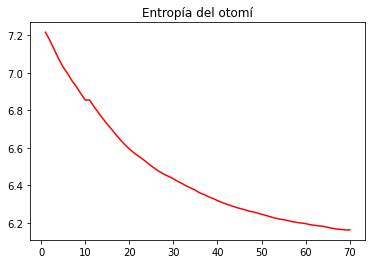

In [ ]:
# mostrando la entropia 
plt.plot(range(1,len(h_otomi)+1),h_otomi,c="red")
plt.title("Entropía del otomí")
plt.show()

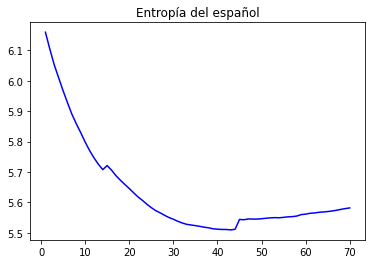

In [ ]:
plt.plot(range(1,len(h_español)+1),h_español,c="blue")
plt.title("Entropía del español")
plt.show()

## Gráfica de la evolución de la entropía de ambas lenguas

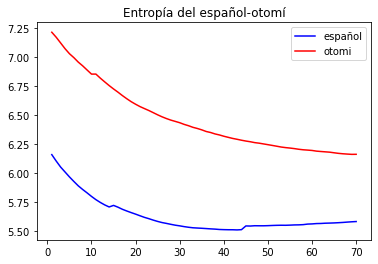

In [ ]:
plt.plot(range(1,len(h_español)+1),h_español,c="blue",label="español")
plt.plot(range(1,len(h_otomi)+1),h_otomi,c="red",label="otomi")
plt.title("Entropía del español-otomí")
plt.legend()
plt.show()

## Curvas de Zipf

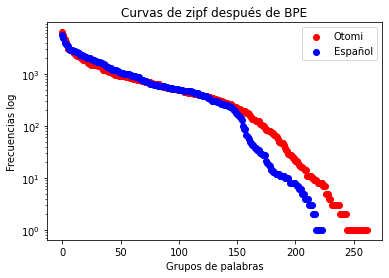

In [ ]:
from itertools import chain
freqs_otomi = Counter(list(chain(*[oracion.split(" ") 
                      for oracion in nuevo_otomi])))
freqs_español = Counter(list(chain(*[oracion.split(" ") 
                      for oracion in nuevo_español])))
zipf_otomi = [x[1] for x in freqs_ordenado(freqs_otomi)]
zipf_español = [x[1] for x in freqs_ordenado(freqs_español)]

plt.scatter(range(len(zipf_otomi)),zipf_otomi,color="red",label="Otomi")
plt.scatter(range(len(zipf_español)),zipf_español,color="blue",label="Español")
plt.yscale("log")
plt.legend()
plt.ylabel("Frecuencias log")
plt.xlabel("Grupos de palabras")
plt.title("Curvas de zipf después de BPE")
plt.show()

# Comparación con subword-nmt

## Instalación e importación de bibliotecas

In [ ]:
!pip install subword-nmt 
# https://github.com/rsennrich/subword-nmt

In [ ]:
import os 
import elotl.corpus
import matplotlib.pyplot as plt
from itertools import chain

## Ejecución BPE con Subword-mnt

### Preprocesamiento

In [ ]:
# creando archivos
corpus_otomi_2 = pre_proceso(otomi)
corpus_español_2 = pre_proceso(español)

with open("/train.nlp.es","w") as p:
  p.writelines([" ".join(oracion)+"\n" for oracion in corpus_español_2])

with open("/train.nlp.ot","w") as p: 
  p.writelines([" ".join(oracion)+"\n" for oracion in corpus_otomi_2])

In [ ]:
!chmod 777 -R /usr/local/lib/python3.7/dist-packages/subword_nmt

### Función auxiliar

In [ ]:
#! /usr/local/lib/python3.7/dist-packages/subword_nmt/learn_joint_bpe_and_vocab.py --input /train.nlp.es /train.nlp.ot -s {num_op} -o /bpe.codes.{num_op} --write-vocabulary /vocab.es /vocab.ot 
#! /usr/local/lib/python3.7/dist-packages/subword_nmt/learn_bpe.py -s {num_op} < /train.nlp.es > /bpe.codes.{num_op}
#! /usr/local/lib/python3.7/dist-packages/subword_nmt/apply_bpe.py -c /bpe.codes.{num_op} < /train.nlp.es > /salida.{num_op}.es

In [ ]:
def ejecutar_subword_nmt(sufijo,iteraciones):
  num_op = 1
  list_h = list()
  for i in range(iteraciones):
    # ejecutamos subword-nmt
    ! /usr/local/lib/python3.7/dist-packages/subword_nmt/learn_bpe.py -s {num_op} < /train.nlp.{sufijo} > /bpe.codes.{sufijo}.{num_op}
    ! /usr/local/lib/python3.7/dist-packages/subword_nmt/apply_bpe.py -c /bpe.codes.{sufijo}.{num_op} < /train.nlp.{sufijo} > /salida.{num_op}.{sufijo}

    # abrimos el corpus de salida
    with open("/salida."+str(num_op)+"."+sufijo,"r") as f:
      data = f.readlines()

    # obtenemos las palabras
    l_bpe = " ".join(data).replace("\n","")
    palabras = [x for x in l_bpe.split(" ") if len(x)>0]
    # calculamos la entropia
    H = entropia(palabras)

    # encontramos el elemento que se juntó
    with open("/bpe.codes."+sufijo+"."+str(num_op),"r") as f:
      datos = f.readlines()
    
    datos = [oracion for oracion in datos if len(oracion)>0]
    mf = datos[-1][:-1].replace("</w>","").replace(" ","")
    print("ITERACION {} \tNuevo más frecuente: {} \tEntropía {}".format(num_op,
                                                                        mf,
                                                                        round(H,2)))
    list_h.append(H)
    num_op+=1
  return data,list_h

### Ejecución

In [ ]:
nuevo_español_2,h_español_2 = ejecutar_subword_nmt("es",150)

ITERACION 1 	Nuevo más frecuente: os 	Entropía 7.32
ITERACION 2 	Nuevo más frecuente: er 	Entropía 7.28
ITERACION 3 	Nuevo más frecuente: de 	Entropía 7.24
ITERACION 4 	Nuevo más frecuente: en 	Entropía 7.21
ITERACION 5 	Nuevo más frecuente: es 	Entropía 7.17
ITERACION 6 	Nuevo más frecuente: es 	Entropía 7.14
ITERACION 7 	Nuevo más frecuente: qu 	Entropía 7.13
ITERACION 8 	Nuevo más frecuente: ca 	Entropía 7.1
ITERACION 9 	Nuevo más frecuente: co 	Entropía 7.07
ITERACION 10 	Nuevo más frecuente: ar 	Entropía 7.04
ITERACION 11 	Nuevo más frecuente: as 	Entropía 7.02
ITERACION 12 	Nuevo más frecuente: an 	Entropía 6.99
ITERACION 13 	Nuevo más frecuente: los 	Entropía 6.97
ITERACION 14 	Nuevo más frecuente: en 	Entropía 6.95
ITERACION 15 	Nuevo más frecuente: do 	Entropía 6.92
ITERACION 16 	Nuevo más frecuente: la 	Entropía 6.9
ITERACION 17 	Nuevo más frecuente: que 	Entropía 6.88
ITERACION 18 	Nuevo más frecuente: tr 	Entropía 6.86
ITERACION 19 	Nuevo más frecuente: el 	Entropía 6.85
IT

In [ ]:
nuevo_otomi_2, h_otomi_2 = ejecutar_subword_nmt("ot",250)

ITERACION 1 	Nuevo más frecuente: ra 	Entropía 8.06
ITERACION 2 	Nuevo más frecuente: ya 	Entropía 8.02
ITERACION 3 	Nuevo más frecuente: ts 	Entropía 7.99
ITERACION 4 	Nuevo más frecuente: bi 	Entropía 7.95
ITERACION 5 	Nuevo más frecuente: 'a 	Entropía 7.92
ITERACION 6 	Nuevo más frecuente: nu 	Entropía 7.88
ITERACION 7 	Nuevo más frecuente: u̱ 	Entropía 7.86
ITERACION 8 	Nuevo más frecuente: th 	Entropía 7.82
ITERACION 9 	Nuevo más frecuente: e̱ 	Entropía 7.8
ITERACION 10 	Nuevo más frecuente: t' 	Entropía 7.77
ITERACION 11 	Nuevo más frecuente: ng 	Entropía 7.74
ITERACION 12 	Nuevo más frecuente: u̱ 	Entropía 7.71
ITERACION 13 	Nuevo más frecuente: di 	Entropía 7.69
ITERACION 14 	Nuevo más frecuente: ni 	Entropía 7.66
ITERACION 15 	Nuevo más frecuente: mi 	Entropía 7.63
ITERACION 16 	Nuevo más frecuente: o̱ 	Entropía 7.62
ITERACION 17 	Nuevo más frecuente: da 	Entropía 7.6
ITERACION 18 	Nuevo más frecuente: ts' 	Entropía 7.58
ITERACION 19 	Nuevo más frecuente: b' 	Entropía 7.56
ITE

## Resultados

### Gráfica de evolución de la entropía separada por lengua con subword-nmt

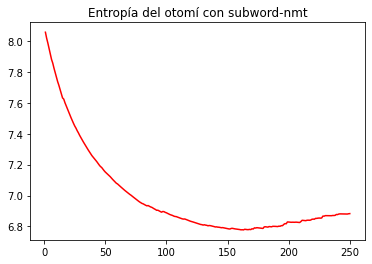

In [ ]:
# mostrando la entropia 
plt.plot(range(1,len(h_otomi_2)+1),h_otomi_2,c="red")
plt.title("Entropía del otomí con subword-nmt")
plt.show()

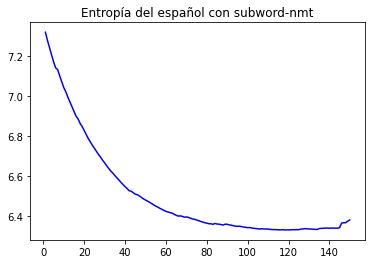

In [ ]:
plt.plot(range(1,len(h_español_2)+1),h_español_2,c="blue")
plt.title("Entropía del español con subword-nmt")
plt.show()

### Gráfica de la evolución de la entropía de ambas lenguas

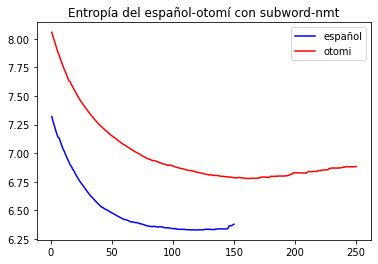

In [ ]:
plt.plot(range(1,len(h_español_2)+1),h_español_2,c="blue",label="español")
plt.plot(range(1,len(h_otomi_2)+1),h_otomi_2,c="red",label="otomi")
plt.title("Entropía del español-otomí con subword-nmt")
plt.legend()
plt.show()

### Gráfica de la evolución de la entropía de ambas lenguas ambos metodos

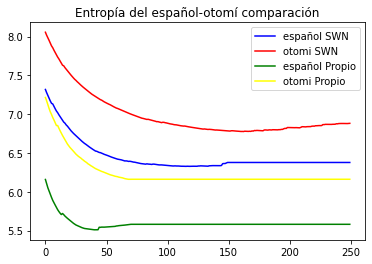

In [ ]:
tam = max([len(h_español),len(h_otomi),len(h_otomi_2),len(h_español_2)])

he_s = h_español_2 + ([h_español_2[-1]]*(tam-len(h_español_2)))
ho_s = h_otomi_2 + ([h_otomi_2[-1]]*(tam-len(h_otomi_2)))
he_p = h_español + ([h_español[-1]]*(tam-len(h_español)))
ho_p = h_otomi + ([h_otomi[-1]]*(tam-len(h_otomi)))

plt.plot(range(tam),he_s,c="blue",label="español SWN")
plt.plot(range(tam),ho_s,c="red",label="otomi SWN")
plt.plot(range(tam),he_p,c="green",label="español Propio")
plt.plot(range(tam),ho_p,c="yellow",label="otomi Propio")
plt.title("Entropía del español-otomí comparación")
plt.legend()
plt.show()

### Curvas de Zipf subword-nmt

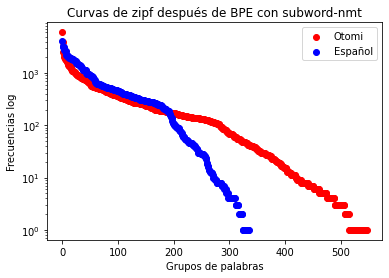

In [ ]:
from itertools import chain
freqs_otomi = Counter(list(chain(*[oracion.split(" ") 
                      for oracion in nuevo_otomi_2])))
freqs_español = Counter(list(chain(*[oracion.split(" ") 
                      for oracion in nuevo_español_2])))
zipf_otomi = [x[1] for x in freqs_ordenado(freqs_otomi)]
zipf_español = [x[1] for x in freqs_ordenado(freqs_español)]

plt.scatter(range(len(zipf_otomi)),zipf_otomi,color="red",label="Otomi")
plt.scatter(range(len(zipf_español)),zipf_español,color="blue",label="Español")
plt.yscale("log")
plt.legend()
plt.ylabel("Frecuencias log")
plt.xlabel("Grupos de palabras")
plt.title("Curvas de zipf después de BPE con subword-nmt")
plt.show()

### Oraciones

In [ ]:
print("Segmentación por Subword-nmt")
print(nuevo_español_2[0])
print("Segmentación por BPE propio")
print(nuevo_español[0])
print("\nOriginal")
print(" ".join(corpus_español_2[0]))

Segmentación por Subword-nmt
ar@@ de se ca@@ l@@ ci@@ n@@ a su co@@ r@@ a@@ z@@ ón y su cu@@ er@@ p@@ o est@@ á d@@ ol@@ i@@ ente de i@@ gu@@ al mo@@ do a m@@ í me ar@@ de y se ca@@ l@@ ci@@ n@@ a m@@ i co@@ r@@ a@@ z@@ ón

Segmentación por BPE propio
ar@@ de se c@@ al@@ c@@ in@@ a su c@@ or@@ a@@ z@@ ón y su cu@@ er@@ p@@ o es@@ t@@ á do@@ l@@ i@@ en@@ te de i@@ gu@@ al mo@@ do a m@@ í me ar@@ de y se c@@ al@@ c@@ in@@ a mi c@@ or@@ a@@ z@@ ón

Original
arde se calcina su corazón y su cuerpo está doliente de igual modo a mí me arde y se calcina mi corazón


In [ ]:
print("Segmentación por Subword-nmt")
print(nuevo_otomi_2[0])
print("Segmentación por BPE propio")
print(nuevo_otomi[0])
print("\nOriginal")
print(" ".join(corpus_otomi_2[0]))

Segmentación por Subword-nmt
z@@ o̱ da z@@ o@@ t'i ri nd@@ ä@@ te ne ri ng@@ o̱@@ k'@@ e@@ i ya@@ bu̱ xa ñ'@@ u̱ ma@@ hy@@ e̱@@ gi nu@@ gi z@@ o̱ ne da z@@ ä@@ t'i ma nd@@ ä@@ te

Segmentación por BPE propio
z@@ o̱ da z@@ o@@ t'i ri nd@@ ä@@ te ne ri ng@@ o̱@@ k@@ 'e@@ i ya@@ bu̱ xa ñ@@ 'u̱ ma@@ h@@ y@@ e̱@@ gi nu@@ gi z@@ o̱ ne da z@@ ä@@ t'i ma nd@@ ä@@ te

Original
zo̱ da zot'i ri ndäte ne ri ngo̱k'ei yabu̱ xa ñ'u̱ mahye̱gi nugi zo̱ ne da zät'i ma ndäte


# Conclusiones
Nuestra implementación consigue mejores resultados respecto a la entropía de la segmentación. Subword-NMT tiene mejores resultados, pero tarda más iteraciones en obtener un valor de entropía bueno. Al final, vemos como con 150 iteraciones para el Español y 250 para el otomí, la entropía de los lenguajes empieza a empeorar.